In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
query_date = '2010-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('T') --, 'BA', 'MMM', 'GA', 'GM', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    limit 100
    ),
    stocks as (
        select 
            market_datetime
            , extract(year from market_datetime) as _year
            , extract(month from market_datetime) as month_of_year
            , extract(week from market_datetime) as week_of_year
            , symbol
            , sector
            , industry
            , (open + close) / 2 as average_price_today
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_volume_fifty_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg((open - close)/open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg((high - low)/high) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            , avg(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_average
            , max(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_high
            , min(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_low
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{query_date}'
        ),
    summary as (
        select *
            , row_number() over (partition by _year, month_of_year, week_of_year) as week_partition
            , (average_open_hundred_days - average_open_fifty_days) / average_open_hundred_days 
                as hundred_fifty_average_open_diff
            , (average_open_fifty_days - average_open_ten_days) / average_open_fifty_days 
                as fifty_ten_average_open_diff
            , (high_open_hundred_days - low_open_hundred_days) / high_open_hundred_days 
                as hundred_high_low_open_diff
            , (average_volume_hundred_days - average_volume_fifty_days) / average_volume_hundred_days 
                as hundred_fifty_average_volume_diff
            , (average_volume_fifty_days - average_volume_ten_days) / average_volume_fifty_days 
                as fifty_ten_average_volume_diff
            --, (forward_average - average_price_today) / average_price_today as target
            --, (forward_high - forward_low) / forward_average as target
            --, forward_average as target
        from stocks
        where forward_average is not null
        and market_datetime > '{query_date}'::date + interval '100' day)
    select *
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, sector) as sector_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime, sector) as sector_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_volume_diff
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, industry) as industry_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime, industry) as industry_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_volume_diff
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime) as market_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime) as market_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime) as market_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime) as market_fifty_ten_average_volume_diff
        , lead(forward_average) over (partition by symbol order by market_datetime) - forward_average as target
    from summary
    where week_partition = 1
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,_year,month_of_year,week_of_year,symbol,sector,industry,average_price_today,volume,average_open_hundred_days,...,sector_fifty_ten_average_volume_diff,industry_hundred_fifty_average_open_diff,industry_fifty_ten_average_open_diff,industry_hundred_high_low_open_diff,industry_fifty_ten_average_volume_diff,market_hundred_fifty_average_open_diff,market_fifty_ten_average_open_diff,market_hundred_high_low_open_diff,market_fifty_ten_average_volume_diff,target
0,2010-04-12 05:00:00,2010.0,4.0,15.0,T,Public Utilities,Telecommunications Equipment,26.475,22940169.0,25.859265,...,-0.030665,0.010595,-0.021752,0.137282,-0.030665,0.010595,-0.021752,0.137282,-0.030665,-0.109512
1,2010-04-19 05:00:00,2010.0,4.0,16.0,T,Public Utilities,Telecommunications Equipment,26.235,33301205.0,25.881781,...,-0.083025,0.009213,-0.020290,0.137282,-0.083025,0.009213,-0.020290,0.137282,-0.083025,-0.195610
2,2010-04-26 05:00:00,2010.0,4.0,17.0,T,Public Utilities,Telecommunications Equipment,26.250,17782577.0,25.910513,...,-0.109881,0.006149,-0.020818,0.137282,-0.109881,0.006149,-0.020818,0.137282,-0.109881,-0.130000
3,2010-05-03 05:00:00,2010.0,5.0,18.0,T,Public Utilities,Telecommunications Equipment,26.260,27076464.0,25.924699,...,-0.112832,0.003260,-0.014874,0.137282,-0.112832,0.003260,-0.014874,0.137282,-0.112832,-0.086098
4,2010-05-10 05:00:00,2010.0,5.0,19.0,T,Public Utilities,Telecommunications Equipment,25.720,40844772.0,25.916591,...,-0.217222,-0.000033,-0.002729,0.137282,-0.217222,-0.000033,-0.002729,0.137282,-0.217222,0.146098


### Clean data

In [3]:
df['market_datetime_month'] = df['market_datetime'].dt.month
df['market_datetime_day_of_week'] = df['market_datetime'].dt.dayofweek

df['market_datetime_int'] = df['market_datetime'].astype(int)

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry', 
                                       'market_datetime_month', 'market_datetime_day_of_week'])

In [4]:
cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'market_datetime_month', 'market_datetime_day_of_week', 
                  'forward_average', 'forward_high', 'forward_low', 'target']

for col in df.drop(cols_to_ignore, axis=1).columns:
    df = cluster_utils.normalize(df=df, column=col)

cluster_utils.normalize(df=df, column='target')
df = df.fillna(1)

In [5]:
df.head(1).T

,0
market_datetime,2010-04-12 05:00:00
_year,0
month_of_year,0.272727
week_of_year,0.269231
symbol,T
...,...
market_datetime_day_of_week_0,1
market_datetime_day_of_week_1,0
market_datetime_day_of_week_2,0
market_datetime_day_of_week_3,0


In [6]:
temp = df.copy()

y = temp['target']

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

### Create nn

In [56]:
model = nn_utils.TorchLSTM(train_x=train_x.drop(cols_to_ignore, axis=1), 
                           train_y=train_y,
                           test_x=test_x.drop(cols_to_ignore, axis=1), 
                           test_y=test_y,
                           n_layers=2,
                           n_epochs=300,
                           hidden_shape=10,
                           dropout=.5,
                           learning_rate=.001,
                           device='cuda:0')

In [57]:
model.execute()

Epoch  0 Error:  152134.390625
Epoch  30 Error:  84774.1640625
Epoch  60 Error:  26415.890625
Epoch  90 Error:  24700.2421875
Epoch  120 Error:  24108.833984375
Epoch  150 Error:  23259.90625
Epoch  180 Error:  22994.994140625
Epoch  210 Error:  22887.109375
Epoch  240 Error:  22819.892578125
Epoch  270 Error:  22608.685546875


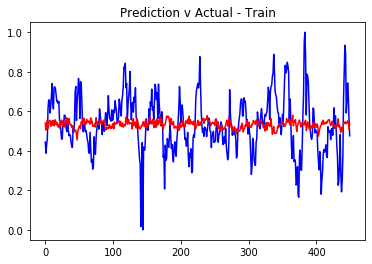

In [58]:
model.plot_prediction_train()

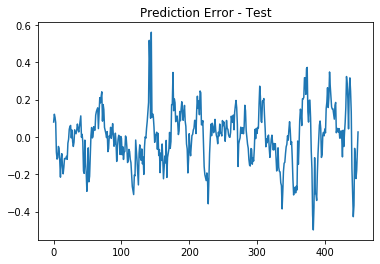

In [59]:
model.plot_prediction_train_error()

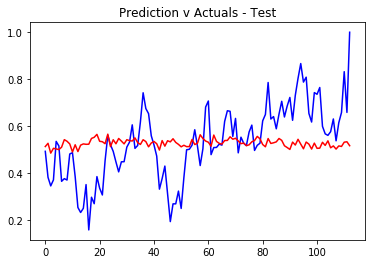

In [60]:
model.plot_prediction_test()

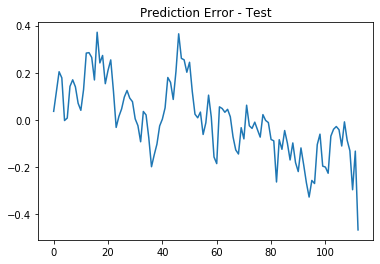

In [61]:
model.plot_prediction_test_error()

In [62]:
model.reset_network()